In [84]:
import sqlite3
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

In [85]:
con = sqlite3.connect('cademycode.db')
curs = con.cursor()

In [86]:
table_structure = curs.execute('''select name from sqlite_master where type='table';''').fetchall()

In [87]:
print(table_structure)

[('cademycode_students',), ('cademycode_courses',), ('cademycode_student_jobs',)]


In [88]:
students = pd.read_sql_query('''select * from cademycode_students''', con)
courses = pd.read_sql_query('''select * from cademycode_courses''', con)
jobs = pd.read_sql_query('''select * from cademycode_student_jobs''', con)

In [89]:
print(students.head())

   uuid             name         dob sex  \
0     1  Annabelle Avery  1943-07-03   F   
1     2      Micah Rubio  1991-02-07   M   
2     3       Hosea Dale  1989-12-07   M   
3     4     Mariann Kirk  1988-07-31   F   
4     5  Lucio Alexander  1963-08-31   M   

                                        contact_info job_id num_course_taken  \
0  {"mailing_address": "303 N Timber Key, Irondal...    7.0              6.0   
1  {"mailing_address": "767 Crescent Fair, Shoals...    7.0              5.0   
2  {"mailing_address": "P.O. Box 41269, St. Bonav...    7.0              8.0   
3  {"mailing_address": "517 SE Wintergreen Isle, ...    6.0              7.0   
4  {"mailing_address": "18 Cinder Cliff, Doyles b...    7.0             14.0   

  current_career_path_id time_spent_hrs  
0                    1.0           4.99  
1                    8.0            4.4  
2                    8.0           6.74  
3                    9.0          12.31  
4                    3.0           5.64  


In [90]:
print(students.dtypes)
#most of these are objects and shouldn't be. Must change that

uuid                       int64
name                      object
dob                       object
sex                       object
contact_info              object
job_id                    object
num_course_taken          object
current_career_path_id    object
time_spent_hrs            object
dtype: object


In [91]:
print(students.info())
#some missing data, will come back for this later

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    5000 non-null   int64 
 1   name                    5000 non-null   object
 2   dob                     5000 non-null   object
 3   sex                     5000 non-null   object
 4   contact_info            5000 non-null   object
 5   job_id                  4995 non-null   object
 6   num_course_taken        4749 non-null   object
 7   current_career_path_id  4529 non-null   object
 8   time_spent_hrs          4529 non-null   object
dtypes: int64(1), object(8)
memory usage: 351.7+ KB
None


In [92]:
#convert dob from object to datetime
#students.dob = pd.to_datetime(students.dob)
#change types for job_id, num_course_taken, current_career_path_id, and time_spent_hrs to float
students = students.astype({'job_id': float, 'num_course_taken': float, 'current_career_path_id': float, 'time_spent_hrs': float})

#add column for actual age
now = pd.to_datetime('now')
students['age'] = round((now - pd.to_datetime(students['dob'])).dt.days / 365)
#add age range to make for some easier graphs
students['age_range'] = round(students['age']/10)*10

#break out contact info into multiple columns
students['contact_info'] = students['contact_info'].apply(lambda x: ast.literal_eval(x))
explode_contact = pd.json_normalize(students['contact_info'])
students = pd.concat([students.drop('contact_info', axis=1), explode_contact], axis=1)

In [93]:
expand_address = students['mailing_address'].str.split(',', expand=True)

In [94]:
students['Street'] = expand_address[0]
students['City'] = expand_address[1]
students['State'] = expand_address[2]
students['Zipcode'] = expand_address[3]
students.drop('mailing_address', axis=1, inplace=True)
print(students.head())
print(students.describe())
print(students.info())

   uuid             name         dob sex  job_id  num_course_taken  \
0     1  Annabelle Avery  1943-07-03   F     7.0               6.0   
1     2      Micah Rubio  1991-02-07   M     7.0               5.0   
2     3       Hosea Dale  1989-12-07   M     7.0               8.0   
3     4     Mariann Kirk  1988-07-31   F     6.0               7.0   
4     5  Lucio Alexander  1963-08-31   M     7.0              14.0   

   current_career_path_id  time_spent_hrs   age  age_range  \
0                     1.0            4.99  81.0       80.0   
1                     8.0            4.40  33.0       30.0   
2                     8.0            6.74  34.0       30.0   
3                     9.0           12.31  36.0       40.0   
4                     3.0            5.64  61.0       60.0   

                            email                   Street              City  \
0  annabelle_avery9376@woohoo.com         303 N Timber Key          Irondale   
1             rubio6772@hmail.com        767 C

In [95]:
print(courses.info())
print(courses.describe())
#nothing missing here and data types make sense

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   career_path_id     10 non-null     int64 
 1   career_path_name   10 non-null     object
 2   hours_to_complete  10 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 372.0+ bytes
None
       career_path_id  hours_to_complete
count        10.00000          10.000000
mean          5.50000          21.900000
std           3.02765           6.707376
min           1.00000          12.000000
25%           3.25000          18.500000
50%           5.50000          20.000000
75%           7.75000          26.500000
max          10.00000          35.000000


In [96]:
print(jobs.info())
print(jobs.describe())
#nothing missing here either and data types still make sense
print(len(jobs.job_category.unique()))
#we have duplicates
jobs = jobs.drop_duplicates(subset='job_category')
#done with this table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   job_id        13 non-null     int64 
 1   job_category  13 non-null     object
 2   avg_salary    13 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 444.0+ bytes
None
          job_id     avg_salary
count  13.000000      13.000000
mean    4.384615   89230.769231
std     2.662657   34727.879881
min     0.000000   10000.000000
25%     3.000000   66000.000000
50%     4.000000   86000.000000
75%     6.000000  110000.000000
max     9.000000  135000.000000
10


In [97]:
#so now need to address the missing data. Let's see if we can find a pattern to what is missing
#first should grab lines of data where something important is missing?
missing_courses = students[students[['num_course_taken']].isnull().any(axis=1)]

<Axes: xlabel='sex'>

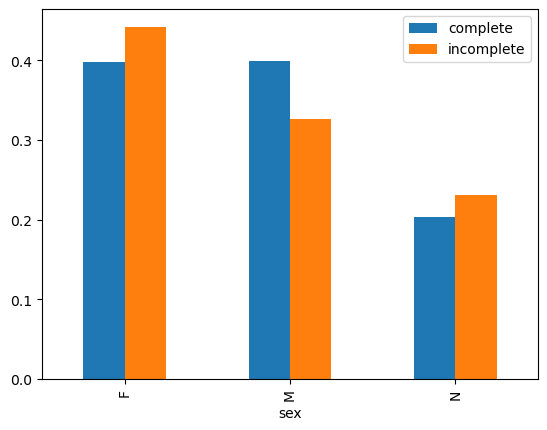

In [98]:
sg = (students.groupby('sex').count()['uuid']/len(students)).rename('complete')
mg = (missing_courses.groupby('sex').count()['uuid']/len(missing_courses)).rename('incomplete')
df = pd.concat([sg,mg], axis=1)
df.plot.bar()

<Axes: xlabel='age_range'>

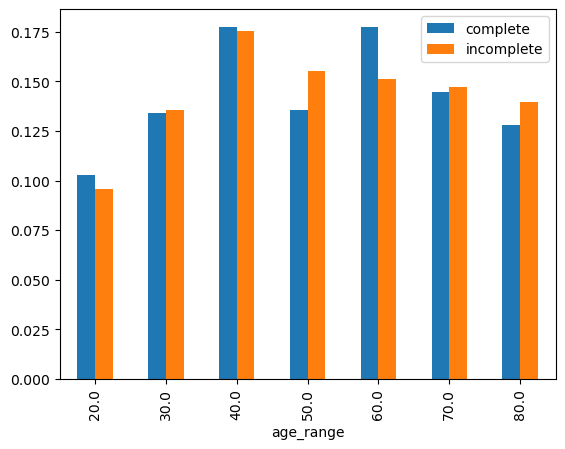

In [99]:
sg = (students.groupby('age_range').uuid.count()/len(students)).rename('complete')
mg = (missing_courses.groupby('age_range').uuid.count()/len(missing_courses)).rename('incomplete')
df = pd.concat([sg,mg], axis=1)
df.plot.bar()

In [100]:
#no pattern detected so MAR. These data is not a time-series, so how much of this data is missing?
perc = len(missing_courses)/len(students)
print(perc)

0.0502


In [101]:
#about 5% is missing, so this is within an ok range to just remove these values.
students.dropna(subset=['num_course_taken'], inplace=True)

In [102]:
print(students.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4749 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4749 non-null   int64  
 1   name                    4749 non-null   object 
 2   dob                     4749 non-null   object 
 3   sex                     4749 non-null   object 
 4   job_id                  4744 non-null   float64
 5   num_course_taken        4749 non-null   float64
 6   current_career_path_id  4298 non-null   float64
 7   time_spent_hrs          4298 non-null   float64
 8   age                     4749 non-null   float64
 9   age_range               4749 non-null   float64
 10  email                   4749 non-null   object 
 11  Street                  4749 non-null   object 
 12  City                    4749 non-null   object 
 13  State                   4749 non-null   object 
 14  Zipcode                 4749 non-null   objec

In [103]:
missing_job_id = students[students[['job_id']].isnull().any(axis=1)]
display(missing_job_id)

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_range,email,Street,City,State,Zipcode
162,163,Glen Riley,2002-08-22,M,NaN,8.0,3.0,5.70,21.0,20.0,glen_riley4484@hmail.com,P.O. Box 37267,Cornlea village,Tennessee,19192
757,758,Mercedez Vorberg,2002-03-25,F,NaN,15.0,4.0,4.14,22.0,20.0,mercedez6297@woohoo.com,284 Cedar Seventh,Virden village,Washington,60489
854,855,Kurt Ho,2002-05-29,M,NaN,0.0,8.0,23.72,22.0,20.0,ho6107@inlook.com,P.O. Box 27254,Olin,New Hampshire,60067
1029,1030,Penny Gaines,2002-03-01,N,NaN,15.0,4.0,16.25,22.0,20.0,gaines2897@hmail.com,138 Misty Vale,Stockton borough,West Virginia,53630
1542,1543,Frederick Reilly,2002-11-13,M,NaN,7.0,9.0,21.32,21.0,20.0,frederick_reilly6971@woohoo.com,P.O. Box 40769,Quakervillage,Maryland,96218


In [104]:
num_in_20_range = len(students[students.age_range==20.0])

In [105]:
print(num_in_20_range)

489


In [106]:
print(len(missing_job_id)/num_in_20_range)

0.010224948875255624


In [107]:
#so even though all are in the age range of 20, so few are missing that this isn't a pattern
students.dropna(subset='job_id', inplace=True)

In [108]:
print(students.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4744 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   float64
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4293 non-null   float64
 7   time_spent_hrs          4293 non-null   float64
 8   age                     4744 non-null   float64
 9   age_range               4744 non-null   float64
 10  email                   4744 non-null   object 
 11  Street                  4744 non-null   object 
 12  City                    4744 non-null   object 
 13  State                   4744 non-null   object 
 14  Zipcode                 4744 non-null   objec

In [109]:
#ok, only need to look at the career path id and time_spent (note that they have the same number of missing rows)
#are they the same missing rows?
missing_career_path = students[students[['current_career_path_id']].isnull().any(axis=1)]
missing_hours = students[students[['time_spent_hrs']].isnull().any(axis=1)]

In [110]:
print(len(missing_career_path))
print(len(missing_hours))
print(missing_career_path['current_career_path_id'].isnull().all())
print(missing_career_path['time_spent_hrs'].isnull().all())
print(missing_hours['current_career_path_id'].isnull().all())
print(missing_hours['time_spent_hrs'].isnull().all())

451
451
True
True
True
True


In [111]:
#ok, same length, so maybe the same rows
print((missing_career_path == missing_hours).all())

uuid                       True
name                       True
dob                        True
sex                        True
job_id                     True
num_course_taken           True
current_career_path_id    False
time_spent_hrs            False
age                        True
age_range                  True
email                      True
Street                     True
City                       True
State                      True
Zipcode                    True
dtype: bool


In [112]:
#ok, so the missing career path and missing hours are exactly the same entries! That's interesting.

In [113]:
#maybe I should add a row to courses to designate that a career path hasn't been chosen?
#I can't just delete this data since it's almost 10% of the remaining data.
#and this data seems to be structurally missing - meaning that no career path has been chosen and no courses have been started.

In [114]:
#ok, so we will add a row for a new career_path_id that corresponds to no selection and then fill the students table
#with corresponding information
courses.loc[len(courses.index)] = [0, 'no selection', 0]

In [115]:
students['current_career_path_id'] = students['current_career_path_id'].fillna(0)
students['time_spent_hrs'] = students['time_spent_hrs'].fillna(0)
print(students.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4744 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   float64
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4744 non-null   float64
 7   time_spent_hrs          4744 non-null   float64
 8   age                     4744 non-null   float64
 9   age_range               4744 non-null   float64
 10  email                   4744 non-null   object 
 11  Street                  4744 non-null   object 
 12  City                    4744 non-null   object 
 13  State                   4744 non-null   object 
 14  Zipcode                 4744 non-null   objec

In [116]:
#now that our tables are fixed, we need to merge into a single table
students_courses = pd.merge(students, courses.rename(columns={'career_path_id': 'current_career_path_id'}))
students_courses_jobs = pd.merge(students_courses, jobs)
print(students_courses_jobs.head())

   uuid             name         dob sex  job_id  num_course_taken  \
0     1  Annabelle Avery  1943-07-03   F     7.0               6.0   
1    15     Tamala Sears  1942-06-01   F     7.0              13.0   
2    24     Eartha Weeks  1954-12-05   F     7.0               2.0   
3   222      Ali de Kock  1960-03-12   M     7.0               4.0   
4   306   Joesph Vermijn  1962-09-24   M     7.0               8.0   

   current_career_path_id  time_spent_hrs   age  age_range  \
0                     1.0            4.99  81.0       80.0   
1                     1.0            4.64  82.0       80.0   
2                     1.0            9.86  69.0       70.0   
3                     1.0           14.87  64.0       60.0   
4                     1.0            9.66  61.0       60.0   

                            email             Street             City  \
0  annabelle_avery9376@woohoo.com   303 N Timber Key         Irondale   
1           tamala4408@woohoo.com  868 Hazy Crossing        

In [117]:
#let's check the info on the table:
print(students_courses_jobs.info())
#looks pretty good to me

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4744 entries, 0 to 4743
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   float64
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4744 non-null   float64
 7   time_spent_hrs          4744 non-null   float64
 8   age                     4744 non-null   float64
 9   age_range               4744 non-null   float64
 10  email                   4744 non-null   object 
 11  Street                  4744 non-null   object 
 12  City                    4744 non-null   object 
 13  State                   4744 non-null   object 
 14  Zipcode                 4744 non-null   

In [118]:
#now need to output as both a csv and a sqlite database
students_courses_jobs.to_csv('final_table.csv')

In [119]:
#sqlite database this time
#need new connection
con_output = sqlite3.connect('final_table.db')
students_courses_jobs.to_sql('cancelled_subs', con_output, if_exists='replace', index=False)

4744